In [1]:
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import os

In [2]:
def discrete_cmap():
    """create a colormap with N (N<15) discrete colors and register it"""
    # define individual colors as hex values
    cpool = ['#DCDCDC', '#b3de69', '#000000', '#8dd3c7', '#fdb462',
             '#fccde5', '#80b1d3', '#808080', '#fb8072', '#696969',
             '#577a4d', '#ffffb3']
    cmap3 = colors.ListedColormap(cpool, 'rooms')
    cm.register_cmap(cmap=cmap3)

    cpool = ['#DCDCDC', '#8dd3c7', '#b15928', '#fdb462', '#ffff99',
             '#fccde5', '#80b1d3', '#808080', '#fb8072', '#696969',
             '#577a4d']
    cmap3 = colors.ListedColormap(cpool, 'icons')
    cm.register_cmap(cmap=cmap3)

    """create a colormap with N (N<15) discrete colors and register it"""
    # define individual colors as hex values
    cpool = ['#DCDCDC', '#b3de69', '#000000', '#8dd3c7', '#fdb462',
             '#fccde5', '#80b1d3', '#808080', '#fb8072', '#696969',
             '#577a4d', '#ffffb3', 'd3d5d7']
    cmap3 = colors.ListedColormap(cpool, 'rooms_furu')
    cm.register_cmap(cmap=cmap3)

    cpool = ['#DCDCDC', '#8dd3c7', '#b15928', '#fdb462', '#ffff99',
             '#fccde5', '#80b1d3', '#808080', '#fb8072', '#696969',
             '#577a4d']
    cmap3 = colors.ListedColormap(cpool, 'rooms_furu')
    cm.register_cmap(cmap=cmap3)
discrete_cmap()

/tmp/ipykernel_1191/2660030060.py:28: UserWarning: Trying to register the cmap 'rooms_furu' which already exists.
  cm.register_cmap(cmap=cmap3)


In [5]:
data_path = '../../CubiCasa5k/data/cubicasa5k/'
with open(data_path + 'test.txt') as f: files = [f'{data_path}{n[1:-1]}F1_original.png'  for n in f.readlines()]
print('\n'.join(f'{i}, {f}' for i,f in enumerate(files[:10])))

0, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/1191/F1_original.png
1, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/2536/F1_original.png
2, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/2530/F1_original.png
3, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/2504/F1_original.png
4, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/2207/F1_original.png
5, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/22/F1_original.png
6, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/2090/F1_original.png
7, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/2085/F1_original.png
8, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/2014/F1_original.png
9, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/2011/F1_original.png


In [11]:
from brute_force import recognize
from recognition import *
import time

verbose = True
with open('./qualitative/all_times.csv', 'w') as f: f.write('area,seg,vect,wall_width,smbl_class,att,norm,att+norm,total\n')

for image_name in tqdm(files[:100]):
    path = f'./qualitative/{"-".join(image_name.split("/")[-3:-1])}/'
    original = cv2.imread(image_name)
    try:
        original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    except:
        original = cv2.cvtColor(original, cv2.COLOR_GRAY2RGB)

    with open('./qualitative/all_times.csv', 'a') as f:
        prediction = recognize(original, verbose)
        f.write(f'{original.shape[0]*original.shape[1]},')
        f.write(f'{prediction["times"]["segmentation"]},')
        f.write(f'{prediction["times"]["vectorization"]},')

        walls, doors, windows, segmentation = prediction['walls'], prediction['doors'], prediction['windows'], prediction['segmentation']

        start = time.perf_counter()
        walls = attach_openings(walls, doors + windows, verbose)
        attach_time = time.perf_counter() - start

        start = time.perf_counter()
        walls = calculate_wall_widths(walls, prediction['segmentation']['walls'], verbose)
        wall_width_time = time.perf_counter() - start
        f.write(f'{wall_width_time},')

        start = time.perf_counter()
        walls = normalize_wall_points(walls, 5)
        normalize_time = time.perf_counter() - start

        start = time.perf_counter()
        walls = classify_wall_elements(walls, original, verbose)
        symbols = classify_symbols(prediction['symbols'], original, verbose)
        symbol_class_time = time.perf_counter() - start
        f.write(f'{symbol_class_time},')

        f.write(f'{attach_time},{normalize_time},{attach_time+normalize_time},')

        total_time = prediction["times"]["segmentation"] + prediction["times"]["vectorization"]+attach_time+wall_width_time+normalize_time+symbol_class_time
        f.write(f'{total_time}\n')

    res = {'walls': walls, 'symbols': symbols}



100%|██████████| 100/100 [23:46<00:00, 14.27s/it]


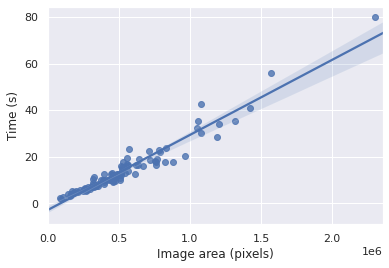

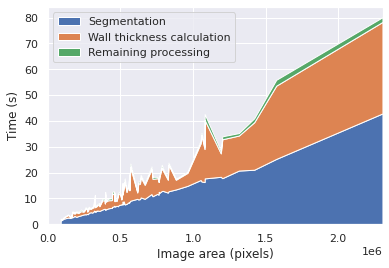

In [64]:
import pandas as pd
import seaborn as sns

sns.set_theme()

times = pd.read_csv('./qualitative/all_times.csv')
times.sort_values(by='area', inplace=True)

sns.regplot(x='area', y='total', data=times, label='Total', truncate=False)
# sns.regplot(x='area', y='seg', data=times, label='Segmentation')
# sns.regplot(x='area', y='vect', data=times, label='Vectorization')
# sns.regplot(x='area', y='wall_width', data=times, label='Wall width')
# plt.legend()
plt.ylabel('Time (s)')
plt.xlabel('Image area (pixels)')
plt.xlim([0, times.area.max()+0.05e6])
plt.savefig('./qualitative/time-by-area.pdf')
plt.show()

remaining = times.vect + times["att+norm"] + times.smbl_class

plt.stackplot(
    times.area, times.seg, times.wall_width, remaining, 
    labels=['Segmentation', 'Wall thickness calculation', 'Remaining processing'])
plt.legend(loc='upper left')
plt.ylabel('Time (s)')
plt.xlabel('Image area (pixels)')
plt.xlim([0, times.area.max()])
plt.savefig('./qualitative/stacked-time-by-area.pdf')

In [63]:
times["seg/total"] = times.seg/times.total * 100
times["width/total"] = times.wall_width/times.total * 100
times["smbl_class/total"] = times.smbl_class/times.total * 100
times["remaining/total"] = remaining/times.total * 100
times.describe()

,area,seg,vect,wall_width,smbl_class,att,norm,att+norm,total,seg/total,width/total,remaining/total,smbl_class/total
count,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,5.306694e+05,8.283212,0.264909,5.255502,0.358446,0.037199,0.003877,0.041076,14.203145,62.457073,32.020832,5.522095,3.352648
std,3.459682e+05,5.804368,0.264502,5.675655,0.155211,0.026666,0.001658,0.027451,11.547165,9.755045,9.826225,2.169942,1.799781
min,8.958500e+04,1.455169,0.014641,0.134477,0.035721,0.006253,0.001543,0.008754,1.873386,38.871519,7.178261,1.467609,0.523802
25%,3.190360e+05,4.924208,0.098322,1.912348,0.251679,0.020896,0.002619,0.025106,7.172234,55.690288,24.731639,4.135444,2.012899
50%,4.611110e+05,7.033496,0.165284,3.753510,0.339416,0.029819,0.003642,0.033654,11.669191,62.800126,32.734114,5.291064,3.111468
75%,6.266678e+05,9.777467,0.334985,6.073796,0.440523,0.045093,0.004679,0.049427,16.922880,68.987134,38.557967,6.780256,4.448635
max,2.304224e+06,42.901142,1.389730,35.410701,0.855667,0.181324,0.010136,0.189040,80.132280,89.015053,54.956154,15.140161,11.425521
